In [1]:
from collections import namedtuple
import os

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

tf.version.VERSION

2023-01-01 04:08:15.053922: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.11.0'

# Load Data using TF Datasets

In [2]:
data = tfds.load('coco/2014')

2023-01-01 04:08:18.398131: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [3]:
print(data.keys())

dict_keys(['test', 'test2015', 'train', 'validation'])


In [4]:
train_data = data['train']
validation_data = data['validation']
test_data = data['test']
print(train_data)
print(validation_data)
print(test_data)

<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'image/id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'objects': {'area': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'bbox': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), 'id': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'is_crowd': TensorSpec(shape=(None,), dtype=tf.bool, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}}>
<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'image/id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'objects': {'area': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'bbox': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), 'id': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'is_crow

In [5]:
class_name = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
    'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench',
    'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
    'backpack', 'umbrella', 'handbag', 'tie', 'suitcase',
    'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop',
    'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
    'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

## Visualize Data

In [6]:
val_it = iter(validation_data)

In [7]:
example_data = next(val_it)

print('image shape: ', example_data['image'].shape)
print('area: ', example_data['objects']['area'].numpy())
print('bbox: ', example_data['objects']['bbox'].numpy())

image shape:  (640, 640, 3)
area:  [100681  33988 218463]
bbox:  [[0.19101563 0.13034375 0.82021874 0.9550625 ]
 [0.34960938 0.35742188 0.77734375 0.91015625]
 [0.02990625 0.026375   0.97473437 0.96996874]]


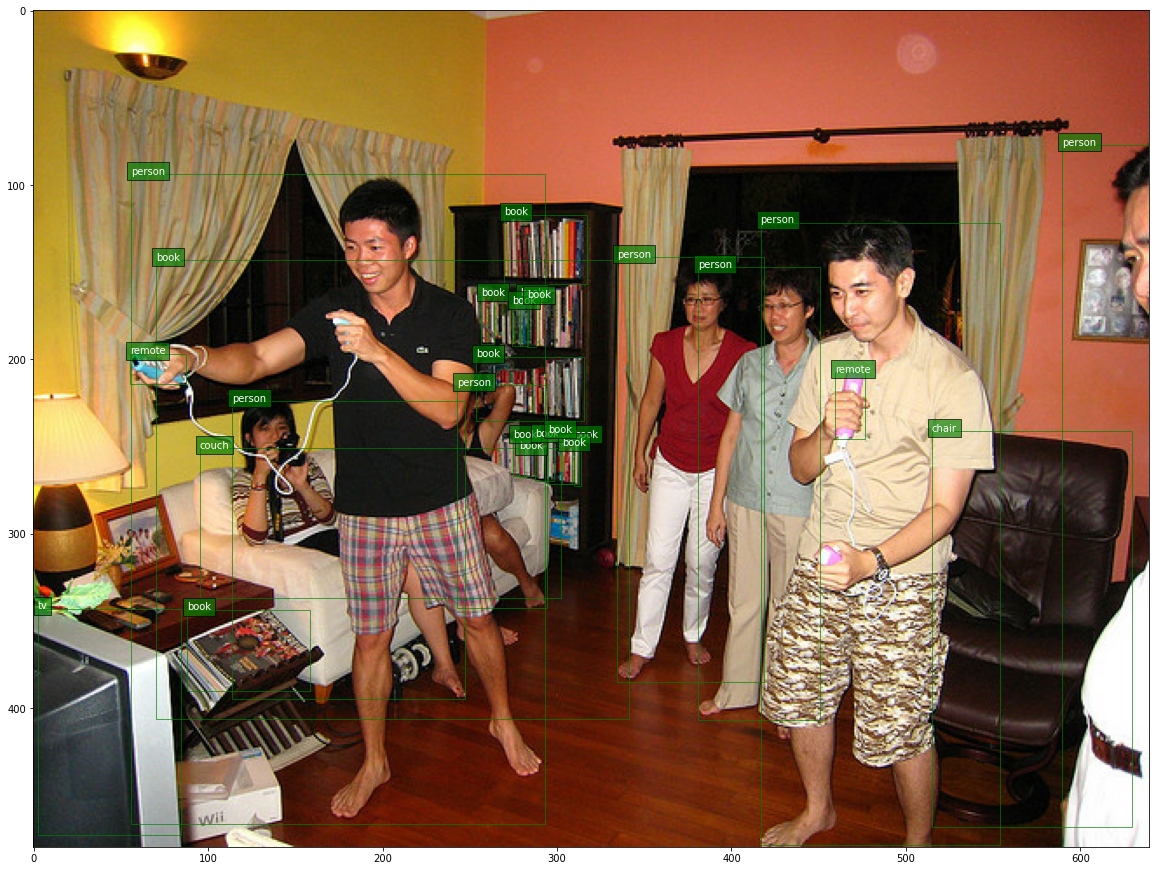

In [8]:
def show_data_pair(image, bbox, label):
    plt.imshow(image)
    ax = plt.gca()
    h, w = image.shape[:2]
    for i, bbox in enumerate(bbox.numpy()):
        ymin = bbox[0] * h
        xmin = bbox[1] * w
        ymax = bbox[2] * h
        xmax = bbox[3] * w
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                 facecolor='none', edgecolor='g', alpha=0.66)
        ax.add_patch(rect)
        
        c = label[i].numpy()
        plt.text(xmin, ymin, class_name[c], color='w', bbox=dict(facecolor='g', alpha=0.66))


example_data = next(val_it)
plt.figure(figsize=(20, 20))

example_image = example_data['image']
example_bbox = example_data['objects']['bbox']
example_label = example_data['objects']['label']
show_data_pair(example_image, example_bbox, example_label)
plt.show()

# Setup Input Pipeline

In [9]:
INPUT_SIZE = (300, 300)

DefaultBox = namedtuple('DefaultBox', ['grid_size', 'scale', 'aspect_ratios'])

default_boxes = [
    DefaultBox(19, 0.2, [1.0, 1.0/2, 2.0]),
    DefaultBox(10, 0.34, [1.0, 1.0/2, 2.0, 1.0/3, 3.0]),
    DefaultBox(5, 0.48, [1.0, 1.0/2, 2.0, 1.0/3, 3.0]),
    DefaultBox(3, 0.62, [1.0, 1.0/2, 2.0, 1.0/3, 3.0]),
    DefaultBox(2, 0.76, [1.0, 1.0/2, 2.0, 1.0/3, 3.0]),
    DefaultBox(1, 0.9, [1.0, 1.0/2, 2.0, 1.0/3, 3.0]),
]

def create_default_box_tensor(default_boxes):
    default_box_tensor = []
    for d, default_box in enumerate(default_boxes):
        for i in range(default_box[0]):
            for j in range(default_box[0]):
                y = (i+0.5) / default_box[0]
                x = (j+0.5) / default_box[0]
                for r in default_box[2]:
                    w = default_box[1] * r
                    h = default_box[1] / r
                    default_box_tensor.append([x, y, w, h])
                    
                if d < len(default_boxes) - 1:
                    next_scale = np.sqrt(default_box[1] * default_boxes[d+1][1])
                else:
                    next_scale = np.sqrt(default_box[1])
                default_box_tensor.append([x, y, next_scale, next_scale])
        print('number of anchors: ', len(default_box_tensor))
    return tf.convert_to_tensor(default_box_tensor)


default_box_tensor = create_default_box_tensor(default_boxes)
print(default_box_tensor)

number of anchors:  1444
number of anchors:  2044
number of anchors:  2194
number of anchors:  2248
number of anchors:  2272
number of anchors:  2278
tf.Tensor(
[[0.02631579 0.02631579 0.2        0.2       ]
 [0.02631579 0.02631579 0.1        0.4       ]
 [0.02631579 0.02631579 0.4        0.1       ]
 ...
 [0.5        0.5        0.3        2.7       ]
 [0.5        0.5        2.7        0.3       ]
 [0.5        0.5        0.9486833  0.9486833 ]], shape=(2278, 4), dtype=float32)


In [10]:
@tf.function
def IOU(default_boxes, bbox):
    top = tf.math.maximum(bbox[0], default_boxes[:, 1] - default_boxes[:, 3] / 2.0)
    left = tf.math.maximum(bbox[1], default_boxes[:, 0] - default_boxes[:, 2] / 2.0)
    bottom = tf.math.minimum(bbox[2], default_boxes[:, 1] + default_boxes[:, 3] / 2.0)
    right = tf.math.minimum(bbox[3], default_boxes[:, 0] + default_boxes[:, 2] / 2.0)
    
    intersect_h = tf.math.maximum(bottom-top, 0)
    intersect_w = tf.math.maximum(right-left, 0)
    intersect_area = intersect_h * intersect_w
    
    bbox_area = tf.abs(bbox[2] - bbox[0]) * tf.abs(bbox[3] - bbox[1])
    anchor_area = default_boxes[:, 2] * default_boxes[:, 3]
    return intersect_area / (anchor_area + bbox_area - intersect_area)


example_data = next(val_it)
IOU(default_box_tensor, example_data['objects']['bbox'][0])

<tf.Tensor: shape=(2278,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , ..., 0.        , 0.09109586,
       0.24557102], dtype=float32)>

In [11]:
@tf.function(experimental_relax_shapes=True)
def compute_target(default_boxes, bboxes, class_label, threshold=tf.constant(0.5)):
    if tf.shape(class_label)[0] == 0:
        return tf.zeros_like(default_boxes), tf.fill([default_boxes.shape[0]], tf.constant(80, tf.int64)), 0
    
    ious = tf.map_fn(lambda x: IOU(default_boxes, x), bboxes)
    best = tf.argmax(ious, axis=1)
    ious += tf.one_hot(best, default_boxes.shape[0])
    indices = tf.argmax(ious, axis=0)
    
    valid_boxes = tf.greater_equal(tf.reduce_max(ious, axis=0), threshold)
    valid_mask = tf.expand_dims(tf.cast(valid_boxes, tf.float32), axis=1)
    num_valid_boxes = tf.reduce_sum(tf.cast(valid_boxes, tf.int32))

    selected_boxes = tf.gather(bboxes, indices)
    selected_labels = tf.gather(class_label, indices)
    
    scaled_x = ((selected_boxes[:, 1] + selected_boxes[:, 3]) / 2.0 - default_boxes[:, 0]) / default_boxes[:, 2]
    scaled_y = ((selected_boxes[:, 0] + selected_boxes[:, 2]) / 2.0 - default_boxes[:, 1]) / default_boxes[:, 3]
    scaled_w = tf.math.log(tf.math.maximum(tf.abs(selected_boxes[:, 3] - selected_boxes[:, 1]) / default_boxes[:, 2], 1e-6))
    scaled_h = tf.math.log(tf.math.maximum(tf.abs(selected_boxes[:, 2] - selected_boxes[:, 0]) / default_boxes[:, 3], 1e-6))
    scaled_box = tf.stack([scaled_x, scaled_y, scaled_w, scaled_h], axis=1)
    
    tf.debugging.assert_all_finite(scaled_w, 'scaled width has Inf value')
    tf.debugging.assert_all_finite(scaled_h, 'scaled height has Inf value')
    
    target_labels = tf.where(valid_boxes, selected_labels, 80)
    
    return scaled_box * valid_mask, target_labels, num_valid_boxes


example_data = next(val_it)
print(example_data['objects']['label'])
target_boxes, target_labels, num_select_boxes = compute_target(default_box_tensor,
                                                               example_data['objects']['bbox'],
                                                               example_data['objects']['label'])

print(target_boxes)
print(target_labels)
print(num_select_boxes)

for i, c in enumerate(target_labels.numpy()):
    if c != 80:
        print(i, c)

train_it = iter(train_data)
for _ in range(32):
    example_data = next(train_it)
    target_boxes, target_labels, num_select_boxes = compute_target(default_box_tensor,
                                                                   example_data['objects']['bbox'],
                                                                   example_data['objects']['label'])

tf.Tensor([13 58 58 58 58], shape=(5,), dtype=int64)
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
2023-01-01 04:08:24.994656: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_13


tf.Tensor(
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 ...
 [ 0. -0.  0. -0.]
 [ 0. -0. -0.  0.]
 [ 0. -0. -0. -0.]], shape=(2278, 4), dtype=float32)
tf.Tensor([80 80 80 ... 80 80 80], shape=(2278,), dtype=int64)
tf.Tensor(11, shape=(), dtype=int32)
1068 58
1154 58
1168 58
1172 58
1280 58
1284 58
1719 13
1725 13
1731 13
2122 13
2127 13


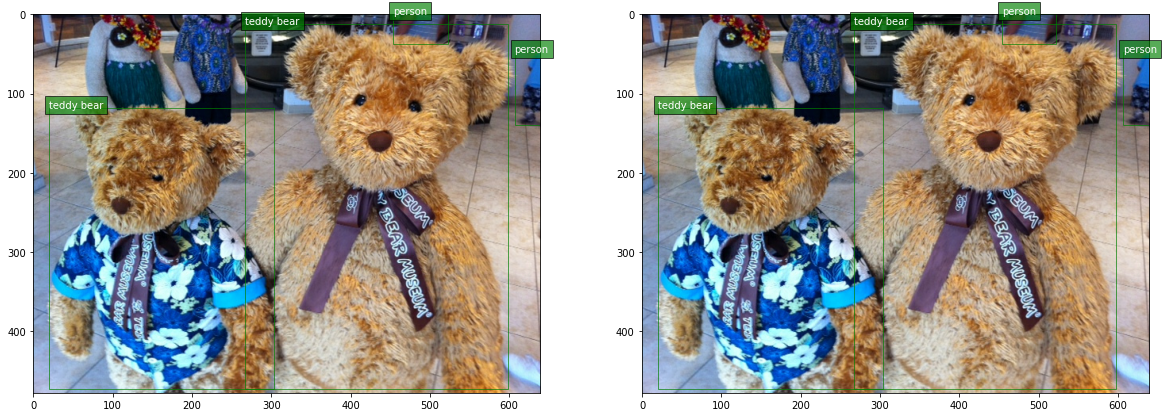

In [12]:
@tf.function(experimental_relax_shapes=True)
def random_flip(image, bbox, label):
    flip = tf.cast(tf.greater_equal(tf.random.uniform((), 0.0, 1.0), 0.5), tf.bool)
    image = tf.where(flip, tf.image.flip_left_right(image), image)
    new_x1 = tf.where(flip, 1.0 - bbox[:, 1], bbox[:, 1])
    new_x2 = tf.where(flip, 1.0 - bbox[:, 3], bbox[:, 3])
    new_xmin = tf.minimum(new_x1, new_x2)
    new_xmax = tf.maximum(new_x1, new_x2)
    new_bbox = tf.stack([bbox[:, 0], new_xmin, bbox[:, 2], new_xmax], axis=1)
    return image, new_bbox, label


example_data = next(val_it)
test_image, test_bbox, test_label = random_flip(example_data['image'],
                                                example_data['objects']['bbox'],
                                                example_data['objects']['label'])

# show the result
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
show_data_pair(example_data['image'], example_data['objects']['bbox'], example_data['objects']['label'])

plt.subplot(1, 2, 2)
show_data_pair(test_image, test_bbox, test_label)
plt.show()

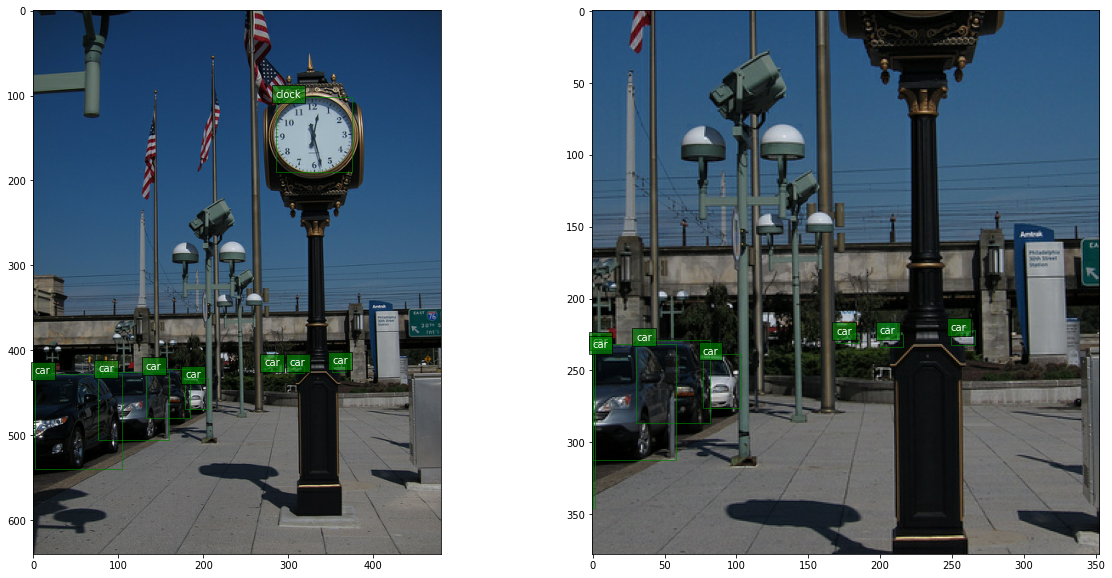

In [13]:
@tf.function(experimental_relax_shapes=True)
def random_crop(image, bbox, label, percent=tf.constant(0.33)):
    left = tf.random.uniform((), 0.0, percent)
    right = tf.random.uniform((), 1.0-percent, 1.0)
    top = tf.random.uniform((), 0.0, percent)
    bottom = tf.random.uniform((), 1.0-percent, 1.0)
    
    new_width = right - left
    new_height = bottom - top
    
    y1 = tf.clip_by_value((bbox[:, 0] - top) / new_height, 0, 1.0)
    x1 = tf.clip_by_value((bbox[:, 1] - left) / new_width, 0, 1.0)
    y2 = tf.clip_by_value((bbox[:, 2] - top) / new_height, 0, 1.0)
    x2 = tf.clip_by_value((bbox[:, 3] - left) / new_width, 0, 1.0)
    valid = tf.logical_and(tf.greater(x2 - x1, 0), tf.greater(y2 - y1, 0))

    new_bbox = tf.stack([y1, x1, y2, x2], axis=1)
    new_bbox = tf.boolean_mask(new_bbox, valid)
    new_label = tf.boolean_mask(label, valid)
    
    image_shape = tf.cast(tf.shape(image), tf.float32)
    left = tf.cast(left * image_shape[1], tf.int32)
    right = tf.cast(right * image_shape[1], tf.int32)
    top = tf.cast(top * image_shape[0], tf.int32)
    bottom = tf.cast(bottom * image_shape[0], tf.int32)
    image = image[top:bottom, left:right, :]
    return image, new_bbox, new_label


example_data = next(val_it)
test_image, test_bbox, test_label = random_crop(example_data['image'],
                                                example_data['objects']['bbox'],
                                                example_data['objects']['label'])

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
show_data_pair(example_data['image'], example_data['objects']['bbox'], example_data['objects']['label'])

plt.subplot(1, 2, 2)
show_data_pair(test_image, test_bbox, test_label)

plt.show()

In [14]:
@tf.function(experimental_relax_shapes=True)
def preprocess(entry):
    image = entry['image']
    bbox = entry['objects']['bbox']
    label = entry['objects']['label']
    image, bbox, label = random_crop(image, bbox, label)
    image, bbox, label = random_flip(image, bbox, label)
    
    image = tf.image.resize(image, INPUT_SIZE)
    
    target_boxes, target_labels, num_select_boxes = compute_target(default_box_tensor, bbox, label)
    targets = tf.concat([target_boxes, tf.one_hot(target_labels, 81)], axis=1)
    return tf.cast(image, tf.float32) / 255.0, targets


it = iter(train_data)
for i in range(32):
    example_data = next(it)
    print(example_data['objects']['label'])
    image, targets = preprocess(example_data)

tf.Tensor([61 71 78 71 61], shape=(5,), dtype=int64)
tf.Tensor([54 54 54 54 54 54 54 54 54 54], shape=(10,), dtype=int64)
tf.Tensor([79 79 79 41], shape=(4,), dtype=int64)
tf.Tensor([ 0 23  0], shape=(3,), dtype=int64)
tf.Tensor([13], shape=(1,), dtype=int64)
tf.Tensor([17 17  0  0], shape=(4,), dtype=int64)
tf.Tensor([ 0  0 29], shape=(3,), dtype=int64)
tf.Tensor([74], shape=(1,), dtype=int64)
tf.Tensor([74], shape=(1,), dtype=int64)
tf.Tensor([18 19 18], shape=(3,), dtype=int64)
tf.Tensor([ 0  0 19], shape=(3,), dtype=int64)
tf.Tensor([61], shape=(1,), dtype=int64)
tf.Tensor([ 0 37], shape=(2,), dtype=int64)
tf.Tensor([ 2  2  2  0 36  7], shape=(6,), dtype=int64)
tf.Tensor([ 0  0 33 33 33 33 33  0], shape=(8,), dtype=int64)
tf.Tensor([10  7], shape=(2,), dtype=int64)
tf.Tensor([14 23], shape=(2,), dtype=int64)
tf.Tensor([62  0  0 13 13 36 56 60], shape=(8,), dtype=int64)
tf.Tensor([58 62 57 60 45 73 73 56 65 75 75], shape=(11,), dtype=int64)
tf.Tensor([ 0  0  0  0  0  0  0 62 73 56 5

In [15]:
BATCH_SIZE = 24
BUFFER_SIZE = 10000

train_ds = train_data.map(preprocess).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
validation_ds = validation_data.map(preprocess).batch(BATCH_SIZE)

print(train_data)
print(validation_data)

<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'image/id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'objects': {'area': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'bbox': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), 'id': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'is_crowd': TensorSpec(shape=(None,), dtype=tf.bool, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}}>
<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'image/id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'objects': {'area': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'bbox': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), 'id': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'is_crow

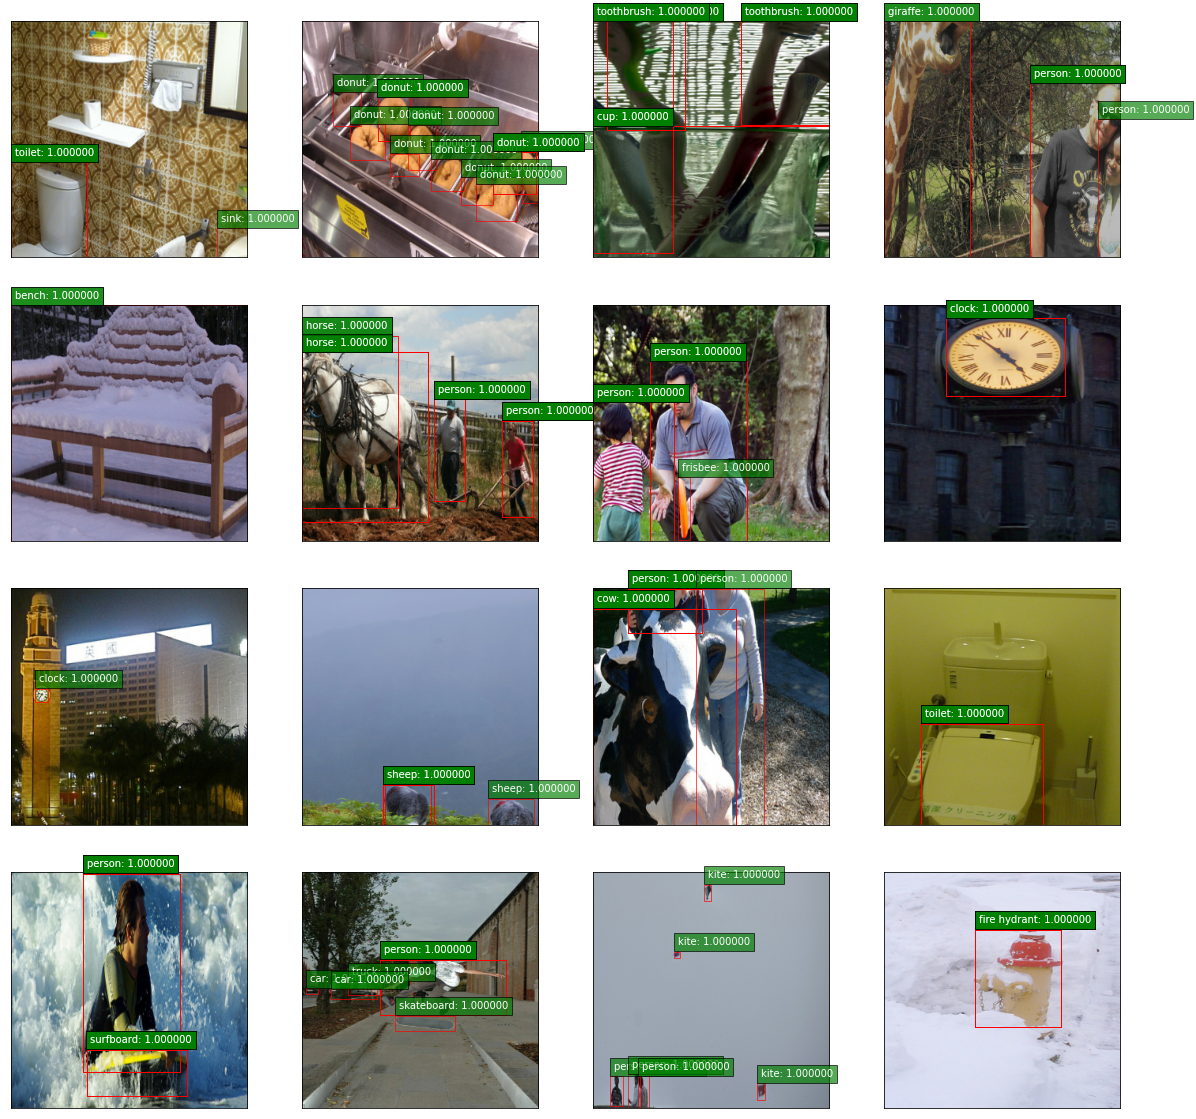

In [16]:
def show_structured_data(image, structured):
    default_box = default_box_tensor.numpy()
    
    plt.imshow(image)
    ax = plt.gca()
    plt.xticks([])
    plt.yticks([])
    for i, row in enumerate(structured):
        box = row[:4]
        confidence = row[4:]
        class_pred = np.argmax(confidence)
        if class_pred != 80:
            cx = box[0] * default_box[i, 2] + default_box[i, 0]
            cy = box[1] * default_box[i, 3] + default_box[i, 1]
            w = np.exp(box[2]) * default_box[i, 2]
            h = np.exp(box[3]) * default_box[i, 3]
            x = cx - w / 2.0
            y = cy - h / 2.0
            sx = x * INPUT_SIZE[0]
            sy = y * INPUT_SIZE[1]
            sw = w * INPUT_SIZE[0]
            sh = h * INPUT_SIZE[1]
            rect = patches.Rectangle((sx, sy), sw, sh,
                                     facecolor='none', edgecolor='r', alpha=0.66)
            ax.add_patch(rect)
            
            text = '%s: %f' % (class_name[class_pred], np.max(confidence))
            plt.text(sx+5, sy-8, text, color='w',
                     bbox=dict(facecolor='g', alpha=0.66))


train_it = iter(train_ds)
# it = iter(validation_ds)

images, labels = next(train_it)

plt.figure(figsize=(20, 20))
for k in range(16):
    plt.subplot(4, 4, k+1)
    show_structured_data(images[k], labels[k].numpy())

plt.show()

# Create Model

In [17]:
keras.backend.clear_session()


def bounding_box_output(x, default_box, name):
    num_box_per_cell = len(default_box[2]) + 1
    total_boxes = default_box[0] * default_box[0] * num_box_per_cell
    
    bx = keras.layers.DepthwiseConv2D(3, 1, padding='same', use_bias=False,
                                      name=name + '_box_depthwise_conv')(x)
    bx = keras.layers.BatchNormalization(name=name + '_box_batchnorm')(bx)
    bx = keras.layers.ReLU(name=name + '_box_relu')(bx)
    box_output = keras.layers.Conv2D(4 * num_box_per_cell, 1, padding='same',
                                     name=name + '_box_logits')(bx)
    box_output = keras.layers.Reshape([total_boxes, 4],
                                      name=name + '_box_logits_reshape')(box_output)
    
    cx = keras.layers.DepthwiseConv2D(3, 1, padding='same', use_bias=False,
                                      name=name + '_class_depthwise_conv')(x)
    cx = keras.layers.BatchNormalization(name=name + '_class_batchnorm')(cx)
    cx = keras.layers.ReLU(name=name + '_class_relu')(cx)
    class_output = keras.layers.Conv2D(81 * num_box_per_cell, 1, padding='same',
                                       activation='softmax',
                                       name=name + '_class_logits')(cx)
    class_output = keras.layers.Reshape([total_boxes, 81],
                                        name=name + '_class_logits_reshape')(class_output)
    
    output = keras.layers.Concatenate(axis=2)([box_output, class_output])
    return output


def lite_conv(x, output_size, ksize, stride):
    x = keras.layers.DepthwiseConv2D(3, stride, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.Conv2D(output_size, 1, 1, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    return x


def build_model():
    input_tensor = keras.layers.Input(shape=[300, 300, 3])
    mobilenet = keras.applications.MobileNetV2(input_tensor=input_tensor,
                                               weights='imagenet')
    
    l1 = mobilenet.get_layer('block_13_expand_relu')
    output1 = bounding_box_output(l1.output, default_boxes[0], 'bbox_output_1')
    l2 = mobilenet.get_layer('out_relu')
    output2 = bounding_box_output(l2.output, default_boxes[1], 'bbox_output_2')
    
    x = lite_conv(l2.output, 256, 3, 1)
    x = lite_conv(x, 512, 3, 2)
    x = lite_conv(x, 512, 3, 1)
    output3 = bounding_box_output(x, default_boxes[2], 'bbox_output_3')
    
    x = lite_conv(x, 128, 3, 1)
    x = lite_conv(x, 256, 3, 2)
    x = lite_conv(x, 256, 3, 1)
    output4 = bounding_box_output(x, default_boxes[3], 'bbox_output_4')
    
    x = lite_conv(x, 128, 3, 1)
    x = lite_conv(x, 256, 3, 2)
    x = lite_conv(x, 256, 3, 1)
    output5 = bounding_box_output(x, default_boxes[4], 'bbox_output_5')
    
    x = lite_conv(x, 64, 3, 1)
    x = lite_conv(x, 128, 3, 2)
    x = lite_conv(x, 128, 3, 1)
    output6 = bounding_box_output(x, default_boxes[5], 'bbox_output_6')
    
    all_output = tf.keras.layers.Concatenate(axis=1, name='all_output')([output1, output2, output3, output4, output5, output6])
    
    model = keras.models.Model(inputs=[input_tensor], outputs=[all_output])
    return model


model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 150, 150, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 150, 150, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [18]:
@tf.function
def ssd_loss(y_true, y_pred):
    num_category = tf.shape(y_pred)[2] - 4

    box_true, class_true = tf.split(y_true, [4, num_category], axis=-1)
    box_pred, class_pred = tf.split(y_pred, [4, num_category], axis=-1)
  
    # confidence loss
    cat = tf.argmax(class_true, axis=2)
    neg_mask = tf.equal(tf.cast(cat, tf.int32), num_category - 1)
    pos_mask = tf.logical_not(neg_mask)
    pos_mask = tf.cast(pos_mask, tf.float32)
    neg_mask = tf.cast(neg_mask, tf.float32)

    num_positives = tf.reduce_sum(pos_mask)
    num_negatives = tf.math.maximum(num_positives * 3, 64)
    # print('number of positives: ', num_positives)
    # print('number of negatives: ', num_negatives)
    loss = tf.keras.losses.categorical_crossentropy(class_true, class_pred, from_logits=False)
    
    neg_losses = loss * neg_mask
    neg_losses = tf.reshape(neg_losses, [-1])
    top_neg_losses, top_indices = tf.math.top_k(neg_losses, tf.cast(num_negatives, tf.int32))
    # print('top neg losses: ', top_neg_losses)
    # print('top indices for neg losses', top_indices)
    # print(tf.boolean_mask(loss, tf.cast(pos_mask, tf.bool)))
    # print(tf.boolean_mask(tf.nn.softmax(class_pred), tf.cast(pos_mask, tf.bool)))
    positive_conf_loss = tf.reduce_sum(loss * pos_mask)
    negative_conf_loss = tf.reduce_sum(top_neg_losses)
  
    # print('negative conf loss: ', negative_conf_loss)
    # print('positive conf loss: ', positive_conf_loss)
    num_samples = num_positives + num_negatives
    conf_loss = (positive_conf_loss + negative_conf_loss) / num_samples
    # print('conf loss: ', conf_loss)

    # localization loss
    # print(tf.reduce_sum(tf.abs(box_true - box_pred) * tf.expand_dims(pos_mask, axis=-1)) / num_positives)
    loc_loss = tf.keras.losses.Huber()(box_true, box_pred * tf.expand_dims(pos_mask, axis=-1))
    # print('loc loss: ', loc_loss)
    return loc_loss + conf_loss


test_x, test_y = next(train_it)

y = model(test_x)
print(y.shape)

loss = ssd_loss(test_y, y)
print('loss: ', loss)

(24, 2278, 85)
loss:  tf.Tensor(4.4585295, shape=(), dtype=float32)


In [19]:
@tf.function
def ssd_precision(y_true, y_pred):
    true_box, true_class = tf.split(y_true, [4, 81], axis=2)
    has_obj = tf.equal(true_class[:, :, -1], 0)
    has_obj = tf.cast(has_obj, tf.float32)
    
    pred_box, pred_class = tf.split(y_pred, [4, 81], axis=2)
    
    pc = tf.argmax(pred_class, axis=2)
    tc = tf.argmax(true_class, axis=2)
    same = tf.cast(tf.equal(tc, pc), tf.float32) * has_obj
    
    predicted_true = tf.cast(tf.not_equal(pc, 80), tf.float32)
    return tf.reduce_sum(same) / (tf.reduce_sum(predicted_true) + 1e-6)


ssd_precision(test_y, y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.00034972758>

In [20]:
@tf.function
def ssd_recall(y_true, y_pred):
    true_box, true_class = tf.split(y_true, [4, 81], axis=2)
    has_obj = tf.equal(true_class[:, :, -1], 0)
    has_obj = tf.cast(has_obj, tf.float32)
    
    pred_box, pred_class = tf.split(y_pred, [4, 81], axis=2)
    
    pc = tf.argmax(pred_class, axis=2)
    tc = tf.argmax(true_class, axis=2)
    same = tf.cast(tf.equal(tc, pc), tf.float32) * has_obj
    return tf.reduce_sum(same) / (tf.reduce_sum(has_obj) + 1e-6)


ssd_recall(test_y, y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.043181818>

In [21]:
@tf.function
def ssd_box_error(y_true, y_pred):
    true_box, true_class = tf.split(y_true, [4, 81], axis=2)
    has_obj = tf.equal(true_class[:, :, -1], 0)
    has_obj = tf.cast(has_obj, tf.float32)
    num_object = tf.reduce_sum(has_obj)
    
    pred_box, pred_class = tf.split(y_pred, [4, 81], axis=2)
    
    box_error = true_box - pred_box
    box_error = tf.abs(box_error) * tf.expand_dims(has_obj, axis=2)
    return tf.reduce_sum(box_error) / num_object


ssd_box_error(test_y, y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.822598>

In [22]:
def schedule(epoch, current_lr):
    if epoch == 100:
        return 1e-4
    elif epoch == 160:
        return 1e-5
    return current_lr


optimizer = keras.optimizers.Adam(1e-3)
checkpoint = tf.train.Checkpoint(model=model)
checkpoint_dir = '../checkpoints/mobilenet_v2_ssd'
# if os.path.isdir(checkpoint_dir):
#     checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

metrics = [ssd_box_error, ssd_precision, ssd_recall]
model.compile(optimizer=optimizer,
              loss=ssd_loss,
              metrics=metrics)

callbacks = [keras.callbacks.LearningRateScheduler(schedule, verbose=True)]
history = model.fit(train_ds,
                    epochs=200,
                    validation_data=validation_ds,
                    validation_steps=30,
                    callbacks=callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/200


2023-01-01 04:09:10.549136: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-01 04:09:10.549178: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-01 04:09:10.563292: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-01 04:09:10.563317: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

3450/3450 [==============================] - 463s 125ms/step - loss: 1.1827 - ssd_box_error: 0.7261 - ssd_precision: 0.4825 - ssd_recall: 0.0257 - val_loss: 1.4924 - val_ssd_box_error: 0.7345 - val_ssd_precision: 0.1136 - val_ssd_recall: 0.0131 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/200
3450/3450 [==============================] - 434s 125ms/step - loss: 1.0254 - ssd_box_error: 0.6484 - ssd_precision: 0.5894 - ssd_recall: 0.0540 - val_loss: 1.1425 - val_ssd_box_error: 0.6663 - val_ssd_precision: 0.4245 - val_ssd_recall: 0.0716 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/200
3450/3450 [==============================] - 417s 120ms/step - loss: 0.9788 - ssd_box_error: 0.6305 - ssd_precision: 0.6133 - ssd_recall: 0.0723 - val_loss: 1.0957 - val_ssd_box_error: 0.6679 - val_ssd_precision: 0.4713 - val_ssd_recall: 0.0812 - lr: 0.0010

Epoch 4: LearningRateScheduler setting le

KeyboardInterrupt: 

In [23]:
checkpoint.save('../checkpoints/mobilenet_v2_ssd/mobilenet_v2_ssd')

'../checkpoints/mobilenet_v2_ssd/mobilenet_v2_ssd-1'

# Evaluation

In [ ]:
@tf.function
def regular_process(entry):
    image = entry['image']
    bbox = entry['objects']['bbox']
    label = entry['objects']['label']
    
    image = tf.image.resize(image, input_size)
    
    target_boxes, target_labels, num_select_boxes = compute_target(default_box_tensor, bbox, label)
    targets = tf.concat([target_boxes, tf.one_hot(target_labels, 81)], axis=1)
    return tf.cast(image, tf.float32) / 255.0, targets


test_ds = validation_data.map(regular_process).batch(36).repeat()
test_it = iter(test_ds)

In [ ]:
test_batch_x, test_batch_y = next(test_it)
print(test_batch_x)
print(test_batch_y)

test_pred = model.predict(test_batch_x)
print(test_pred)

In [ ]:
test_batch_x, test_batch_y = next(test_it)
test_pred = model.predict(test_batch_x)

plt.figure(figsize=(20, 100))
n_sample = 10
for n in range(n_sample):
    plt.subplot(n_sample, 2, 2 * n + 1)
    show_structured_data(test_batch_x[n], test_batch_y[n].numpy())
    plt.xlabel('true label')

    plt.subplot(n_sample, 2, 2 * n + 2)
    show_structured_data(test_batch_x[n], test_pred[n])
    plt.xlabel('prediction')
plt.show()

# Normalize Prediction

In [ ]:
@tf.function
def normalize_bbox(prediction, default_box_tensor):
    norm_cx = prediction[:, :, 0] * default_box_tensor[:, 2] + default_box_tensor[:, 0]
    norm_cy = prediction[:, :, 1] * default_box_tensor[:, 3] + default_box_tensor[:, 1]
    norm_w = tf.math.exp(prediction[:, :, 2]) * default_box_tensor[:, 2]
    norm_h = tf.math.exp(prediction[:, :, 3]) * default_box_tensor[:, 3]
    ymin = norm_cy - norm_h / 2.0
    xmin = norm_cx - norm_w / 2.0
    ymax = norm_cy + norm_h / 2.0
    xmax = norm_cx + norm_w / 2.0
    bbox = tf.stack([ymin, xmin, ymax, xmax], axis=2)
    normed_result = tf.concat([bbox, prediction[:, :, 4:]], axis=2)
    return normed_result


def show_normed_prediction(image, normed):
    default_box = default_box_tensor.numpy()
    
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    ax = plt.gca()
    for i, row in enumerate(normed):
        box = row[:4]
        confidence = row[4:]
        class_pred = np.argmax(confidence)
        if class_pred != 80:
            x = box[1]
            y = box[0]
            w = np.abs(box[3] - box[1])
            h = np.abs(box[2] - box[0])
            sx = x * input_size[0]
            sy = y * input_size[1]
            sw = w * input_size[0]
            sh = h * input_size[1]
            rect = patches.Rectangle((sx, sy), sw, sh,
                                     facecolor='none', edgecolor='r', alpha=0.66)
            ax.add_patch(rect)
            
            plt.text(sx, sy, class_name[class_pred], color='w',
                     bbox=dict(facecolor='g', alpha=0.66))


test_batch_x, test_batch_y = next(test_it)
test_pred = model.predict(test_batch_x)
test_norm_pred = normalize_bbox(test_pred, default_box_tensor)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
show_structured_data(test_batch_x[0], test_batch_y[0].numpy())
plt.xlabel('true label')

plt.subplot(1, 2, 2)
show_normed_prediction(test_batch_x[0], test_norm_pred[0].numpy())
plt.xlabel('normalized prediction')

plt.show()

# Non Maximum Suppression

In [ ]:
@tf.function
def non_max_suppress(normed_result,
                     iou_threshold=tf.constant(0.5),
                     score_threshold=tf.constant(0.01),
                     max_output_size=tf.constant(30)):
    bbox = normed_result[:, :4]
    confidence = normed_result[:, 4:]
    class_pred = tf.argmax(confidence, axis=-1)
    scores = tf.reduce_max(confidence, axis=1)
    
    all_boxes = []
    all_scores = []
    all_classes = []
    for i in range(80):
        mask = tf.equal(class_pred, i)
        filtered_boxes = tf.boolean_mask(bbox, mask)
        filtered_scores = tf.boolean_mask(scores, mask)
        filtered_class_pred = tf.boolean_mask(class_pred, mask)
        
        selected_indices = tf.image.non_max_suppression(
            filtered_boxes,
            filtered_scores,
            max_output_size,
            iou_threshold=iou_threshold,
            score_threshold=score_threshold)
        
        selected_box = tf.gather(filtered_boxes, selected_indices)
        selected_score = tf.gather(filtered_scores, selected_indices)
        selected_class = tf.gather(filtered_class_pred, selected_indices)
        
        all_boxes.append(selected_box)
        all_scores.append(selected_score)
        all_classes.append(selected_class)
    
    all_boxes = tf.concat(all_boxes, axis=0)
    all_scores = tf.concat(all_scores, axis=0)
    all_classes = tf.concat(all_classes, axis=0)
    
    sort_indices = tf.argsort(all_scores, direction='ASCENDING')
    
    all_scores = tf.expand_dims(all_scores, axis=1)
    all_classes = tf.expand_dims(all_classes, axis=1)
    
    all_result = tf.concat([all_boxes, all_scores, tf.cast(all_classes, tf.float32)], axis=1)
    
    # sort
    all_result = tf.gather(all_result, sort_indices)
    
    num = tf.shape(all_result)[0]
    max_output_size = max_output_size * 10
    result = tf.cond(num > max_output_size,
                     lambda: all_result[:max_output_size],
                     lambda: tf.pad(all_result, [[0, max_output_size-num], [0, 0]]))
    return result


def show_suppressed_prediction(image, normed):
    default_box = default_box_tensor.numpy()
    
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    ax = plt.gca()
    for i, row in enumerate(normed):
        box = row[:4]
        class_score = row[4]
        class_pred = int(row[5])
        if class_score > 0:
            x = box[1]
            y = box[0]
            w = np.abs(box[3] - box[1])
            h = np.abs(box[2] - box[0])
            sx = x * input_size[0]
            sy = y * input_size[1]
            sw = w * input_size[0]
            sh = h * input_size[1]
            rect = patches.Rectangle((sx, sy), sw, sh,
                                     facecolor='none', edgecolor='r', alpha=0.66)
            ax.add_patch(rect)
        
            text = '%s: %f' % (class_name[class_pred], class_score)
            plt.text(sx, sy, text, color='w',
                     bbox=dict(facecolor='g', alpha=0.66))


# test_batch_x, test_batch_y = next(test_it)
test_pred = model.predict(test_batch_x)
test_norm_pred = normalize_bbox(test_pred, default_box_tensor)

test_suppressed_result = non_max_suppress(test_norm_pred[0])
print(test_suppressed_result.shape)

plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
show_structured_data(test_batch_x[0], test_batch_y[0].numpy())
plt.xlabel('true label')

plt.subplot(1, 3, 2)
show_normed_prediction(test_batch_x[0], test_norm_pred[0].numpy())
plt.xlabel('normalized prediction')

plt.subplot(1, 3, 3)
show_suppressed_prediction(test_batch_x[0], test_suppressed_result.numpy())
plt.xlabel('suppressed prediction')

plt.show()

In [ ]:
@tf.function
def non_max_suppress_all(batched_normed_result):
    result = tf.map_fn(non_max_suppress, batched_normed_result)
    return result


test_batch_x, test_batch_y = next(test_it)
test_pred = model.predict(test_batch_x)
test_norm_pred = normalize_bbox(test_pred, default_box_tensor)

test_suppressed_result = non_max_suppress_all(test_norm_pred)
print(test_suppressed_result.shape)


plt.figure(figsize=(20, 60))
n_sample = 10
for n in range(n_sample):
    plt.subplot(n_sample, 3, n * 3 + 1)
    show_structured_data(test_batch_x[n], test_batch_y[n].numpy())
    plt.xlabel('true label')

    plt.subplot(n_sample, 3, n * 3 + 2)
    show_normed_prediction(test_batch_x[n], test_norm_pred[n].numpy())
    plt.xlabel('normalized prediction')

    plt.subplot(n_sample, 3, n * 3 + 3)
    show_suppressed_prediction(test_batch_x[n], test_suppressed_result[n].numpy())
    plt.xlabel('suppressed prediction')

plt.show()

# Wrap Model

In [ ]:
@tf.function
def post_processing(pred):
    norm_pred = normalize_bbox(pred, default_box_tensor)

    suppressed_result = non_max_suppress_all(norm_pred)
    return suppressed_result


def build_wrapped_model(model):
    output = model.outputs[0]
    output = keras.layers.Lambda(lambda x: post_processing(x))(output)
    wrapped = tf.keras.models.Model(inputs=model.inputs, outputs=[output])
    return wrapped


wrapped_model = build_wrapped_model(model)
wrapped_model.summary()

In [ ]:
wrapped_model.save('../models/mobilenet_v2_ssd.h5')

In [ ]:
test_batch_x, test_batch_y = next(test_it)
test_pred = wrapped_model.predict(test_batch_x)

plt.figure(figsize=(20, 60))
n_sample = 10
for n in range(n_sample):
    plt.subplot(n_sample, 2, n * 2 + 1)
    show_structured_data(test_batch_x[n], test_batch_y[n].numpy())
    plt.xlabel('true label')

    plt.subplot(n_sample, 2, n * 2 + 2)
    show_suppressed_prediction(test_batch_x[n], test_pred[n])
    plt.xlabel('final prediction')
plt.show()

# Save model

In [ ]:
checkpoint_dir = '../checkpoints/mobilenet_v2_ssd'
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
tf.saved_model.save(wrapped_model, '../models/mobilenet_v2_ssd')

### Save as TF Lite model

In [ ]:
loaded_model = tf.saved_model.load('../models/mobilenet_v2_ssd')

concrete_func = loaded_model.signatures[
    tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1, 300, 300, 3])

converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.allow_custom_ops = True
tflite_model = converter.convert()

with open('../models/mobilenet_v2_ssd.tflite', 'wb') as f:
    f.write(tflite_model)

# Load Model and Test

In [ ]:
model = tf.saved_model.load('../models/mobilenet_v2_ssd')

In [ ]:
validation_it = iter(validation_ds)

In [ ]:
def show_suppressed_prediction(image, normed):
    default_box = default_box_tensor.numpy()
    
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    ax = plt.gca()
    for i, row in enumerate(normed):
        box = row[:4]
        class_score = row[4]
        class_pred = int(row[5])
        if class_score > 0:
            x = box[1]
            y = box[0]
            w = np.abs(box[3] - box[1])
            h = np.abs(box[2] - box[0])
            sx = x * input_size[0]
            sy = y * input_size[1]
            sw = w * input_size[0]
            sh = h * input_size[1]
            rect = patches.Rectangle((sx, sy), sw, sh,
                                     facecolor='none', edgecolor='r', alpha=0.66)
            ax.add_patch(rect)
        
            text = '%s: %f' % (class_name[class_pred], class_score)
            plt.text(sx, sy, text, color='w',
                     bbox=dict(facecolor='g', alpha=0.66))


validation_batch_x, validation_batch_y = next(validation_it)
validation_pred = model(validation_batch_x)

plt.figure(figsize=(20, 60))
n_sample = 10
for n in range(n_sample):
    plt.subplot(n_sample, 2, n * 2 + 1)
    show_structured_data(validation_batch_x[n], validation_batch_y[n].numpy())
    plt.xlabel('true label')

    plt.subplot(n_sample, 2, n * 2 + 2)
    show_suppressed_prediction(validation_batch_x[n], validation_pred[n].numpy())
    plt.xlabel('final prediction')
plt.show()